In [2]:
import math
import torch
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt
import numpy as np

from mmdet.apis import init_detector, inference_detector
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector

from mmcv.parallel import collate, scatter
from mmcv.ops import RoIPool
from mmcv import Config, DictAction
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmdet.core.utils import filter_scores_and_topk, select_single_mlvl
from mmdet.core import (bbox2roi, multiclass_nms)

## 1. Init Your config and model

In [3]:
config = '../configs/faster_rcnn/faster_rcnn_r50_caffe_c4_1x_coco.py'
cfg = Config.fromfile(config)
# wget https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_c4_1x_coco/faster_rcnn_r50_caffe_c4_1x_coco_20220316_150152-3f885b85.pth
checkpoint_path = '../checkpoints/faster_rcnn_r50_caffe_c4_1x_coco_20220316_150152-3f885b85.pth'
device = 'cuda:0'
model = init_detector(config)
checkpoint = load_checkpoint(model, checkpoint_path, map_location=device)
label_names = checkpoint['meta']['CLASSES']
model.CLASSES = checkpoint['meta']['CLASSES']

load checkpoint from local path: ../checkpoints/faster_rcnn_r50_caffe_c4_1x_coco_20220316_150152-3f885b85.pth


## Visualize an image

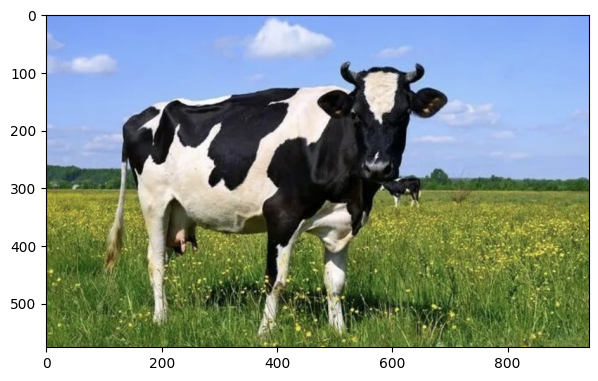

In [4]:
image_path = "../image/cow.png"
image = cv2.imread(image_path)
# scale = 600 / min(image.shape[:2])
# image = cv2.resize(image,
#                    dsize = (448, 448),
#                    interpolation=cv2.INTER_AREA)
plt.figure(figsize=(7, 7))
plt.imshow(image[:, :, ::-1])
plt.show()

## Predict the results with Faster R-CNN C4

/home/cry/J-20/Demo/objectdetection-saliency-maps/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


19 cow (119, 86, 683, 560) 0.99974424
19 cow (579, 281, 650, 336) 0.9754893
19 cow (362, 155, 658, 560) 0.72618985
19 cow (325, 82, 692, 429) 0.4003471


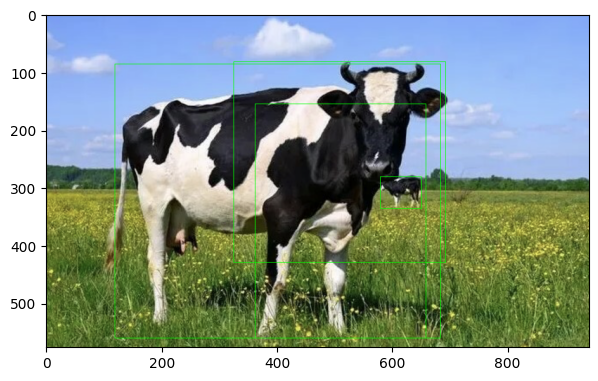

In [5]:
out = inference_detector(model, image)
res = image.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.4:
            break
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (0, 255, 0), 1)

plt.figure(figsize=(7, 7))
plt.imshow(res[:, :, ::-1])
plt.show()

## 2. This is the core demo for Grad CAM

In [6]:
# GPU version
class GradCAM_FRCN(object):
    """
    Grad CAM for Faster R-CNN C4 in mmdetection framework
    """

    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        # print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()
    
    def rpn_get_bboxes(self, cls_scores,
                   bbox_preds,
                   score_factors=None,
                   img_metas=None,
                   cfg=None,
                   rescale=False,
                   with_nms=False,
                   **kwargs):
        assert len(cls_scores) == len(bbox_preds)
        if score_factors is None:
            # e.g. Retina, FreeAnchor, Foveabox, etc.
            with_score_factors = False
        else:
            # e.g. FCOS, PAA, ATSS, AutoAssign, etc.
            with_score_factors = True
            assert len(cls_scores) == len(score_factors)

        num_levels = len(cls_scores)

        featmap_sizes = [cls_scores[i].shape[-2:] for i in range(num_levels)]
        mlvl_priors = self.net.rpn_head.prior_generator.grid_priors(
            featmap_sizes,
            dtype=cls_scores[0].dtype,
            device=cls_scores[0].device)

        result_list = []

        for img_id in range(len(img_metas)):
            img_meta = img_metas[img_id]
            cls_score_list = select_single_mlvl(cls_scores, img_id, detach=False)
            bbox_pred_list = select_single_mlvl(bbox_preds, img_id, detach=False)
            if with_score_factors:
                score_factor_list = select_single_mlvl(score_factors, img_id, detach=False)
            else:
                score_factor_list = [None for _ in range(num_levels)]
            results = self.net.rpn_head._get_bboxes_single(cls_score_list, bbox_pred_list,
                                              score_factor_list, mlvl_priors,
                                              img_meta, cfg, rescale, with_nms,
                                              **kwargs)
            result_list.append(results)
        return result_list
    
    def simple_test_bboxes(self,
                           x,
                           img_metas,
                           proposals,
                           rcnn_test_cfg,
                           rescale=False):
        """Test only det bboxes without augmentation.
        This function needn't read.
        """
        rois = bbox2roi(proposals)
        # print("rois: {}".format(rois.shape))
        if rois.shape[0] == 0:
            batch_size = len(proposals)
            det_bbox = rois.new_zeros(0, 5)
            det_label = rois.new_zeros((0, ), dtype=torch.long)
            if rcnn_test_cfg is None:
                det_bbox = det_bbox[:, :4]
                det_label = rois.new_zeros(
                    (0, self.net.roi_head.bbox_head.fc_cls.out_features))
            # There is no proposal in the whole batch
            return [det_bbox] * batch_size, [det_label] * batch_size

        bbox_results = self.net.roi_head._bbox_forward(x, rois)
        img_shapes = tuple(meta['img_shape'] for meta in img_metas)
        scale_factors = tuple(meta['scale_factor'] for meta in img_metas)

        # split batch bbox prediction back to each image
        cls_score = bbox_results['cls_score']
        bbox_pred = bbox_results['bbox_pred']
        num_proposals_per_img = tuple(len(p) for p in proposals)
        rois = rois.split(num_proposals_per_img, 0)
        cls_score = cls_score.split(num_proposals_per_img, 0)

        # some detector with_reg is False, bbox_pred will be None
        if bbox_pred is not None:
            # TODO move this to a sabl_roi_head
            # the bbox prediction of some detectors like SABL is not Tensor
            if isinstance(bbox_pred, torch.Tensor):
                bbox_pred = bbox_pred.split(num_proposals_per_img, 0)
            else:
                bbox_pred = self.net.roi_head.bbox_head.bbox_pred_split(
                    bbox_pred, num_proposals_per_img)
        else:
            bbox_pred = (None, ) * len(proposals)

        # apply bbox post-processing to each image individually
        det_bboxes = []
        det_labels = []
        for i in range(len(proposals)):
            if rois[i].shape[0] == 0:
                # There is no proposal in the single image
                det_bbox = rois[i].new_zeros(0, 5)
                det_label = rois[i].new_zeros((0, ), dtype=torch.long)
                if rcnn_test_cfg is None:
                    det_bbox = det_bbox[:, :4]
                    det_label = rois[i].new_zeros(
                        (0, self.net.roi_head.bbox_head.fc_cls.out_features))

            else:
                det_bbox, det_label, det_inds = self.get_bboxes(
                    rois[i],
                    cls_score[i],
                    bbox_pred[i],
                    img_shapes[i],
                    scale_factors[i],
                    rescale=rescale,
                    cfg=rcnn_test_cfg)
            
            det_bboxes.append(det_bbox)
            det_labels.append(det_label)
        return det_bboxes, det_labels, det_inds
    
    def get_bboxes(self,
                   rois,
                   cls_score,
                   bbox_pred,
                   img_shape,
                   scale_factor,
                   rescale=False,
                   cfg=None):
        
        scores = F.softmax(
            cls_score, dim=-1) if cls_score is not None else None
        # bbox_pred would be None in some detector when with_reg is False,
        # e.g. Grid R-CNN.
        if bbox_pred is not None:
            bboxes = self.net.roi_head.bbox_head.bbox_coder.decode(
                rois[..., 1:], bbox_pred, max_shape=img_shape)
        else:
            bboxes = rois[:, 1:].clone()
            if img_shape is not None:
                bboxes[:, [0, 2]].clamp_(min=0, max=img_shape[1])
                bboxes[:, [1, 3]].clamp_(min=0, max=img_shape[0])

        if rescale and bboxes.size(0) > 0:
            scale_factor = bboxes.new_tensor(scale_factor)
            bboxes = (bboxes.view(bboxes.size(0), -1, 4) / scale_factor).view(
                bboxes.size()[0], -1)
        if cfg is None:
            return bboxes, scores
        else:
            det_bboxes, det_labels, inds = multiclass_nms(bboxes, scores,     # return_inds=True
                                                    cfg.score_thr, cfg.nms,
                                                    cfg.max_per_img, return_inds=True)
            return det_bboxes, det_labels, inds

    def __call__(self, data, index=0, mode = "proposal"):
        """
        :param image: cv2 format, single image
        :param index: Which bounding box
        "param mode: [proposal, global]
        :return:
        """
        self.net.zero_grad()
        # Important
        feat = self.net.extract_feat(data['img'][0].cuda())

        if type(data['img_metas'][0]) == list:
            img_metas = data['img_metas'][0]
        else:
            img_metas = data['img_metas'][0].data[0]
        
        if mode is "proposal":
            rpn_outs = self.net.rpn_head(feat)
            proposal_list = self.rpn_get_bboxes(*rpn_outs, img_metas=img_metas)
        # print(proposal_list[0].shape)
        # proposal_list = model.rpn_head.simple_test_rpn(feat, img_metas)
        # res = model.roi_head.simple_test(feat, proposal_list, img_metas, rescale=True)
            res = self.simple_test_bboxes(feat, img_metas, proposal_list, self.net.roi_head.test_cfg, rescale=True)
        
            ind = int(res[2][index]/len(self.net.CLASSES))
        elif mode is "global":
            rpn_outs = self.net.rpn_head(feat)
            proposal_list = self.rpn_get_bboxes(*rpn_outs, img_metas=img_metas)
            res= self.net.roi_head.simple_test_bboxes(
            feat, img_metas, proposal_list, self.net.roi_head.test_cfg, rescale=True)
        
        score = res[0][0][index][4]
        score.backward()
        
        if mode is "proposal":
            gradient = self.gradient[ind]  # [C,H,W]
            weight = torch.mean(gradient, axis=(1, 2))  # [C]
            feature = self.feature[ind]  # [C,H,W]

        elif mode is "global":
            gradient = self.gradient[0]    # [C,H,W]
            weight = torch.mean(gradient, axis=(1, 2))  # [C]
            feature = self.feature[0]      # [C,H,W]

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = torch.sum(cam, axis=0)  # [H,W]
        cam = torch.relu(cam)  # ReLU

        # Normalization
        cam -= torch.min(cam)
        cam /= torch.max(cam)

        # resize to 224*224
        box = res[0][0][index][:-1].cpu().detach().numpy().astype(np.int32)
        
        class_id = res[1][0][index].cpu().detach().numpy()
        return cam.cpu().detach().numpy(), box, class_id, score.cpu().detach().numpy()

<>:204: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:222: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:227: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:204: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:222: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:227: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_2862827/3591584588.py:204: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode is "proposal":
/tmp/ipykernel_2862827/3591584588.py:213: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mode is "global":
/tmp/ipykernel_2862827/3591584588.py:222: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if mode is "proposal":
/tmp/ipykernel_2862827/3591584588.py:227: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif mode is "global":


## If you just an image in opencv format, this is a preparation function

In [7]:
def prepare_img(imgs):
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    cfg = model.cfg
    device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)
    # print(datas)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        for m in model.modules():
            assert not isinstance(
                m, RoIPool
            ), 'CPU inference with RoIPool is not supported currently.'

    return data

## These functions are used for rendering images

In [8]:
def norm_image(image):
    """
    :param image: [H,W,C]
    :return:
    """
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)

def gen_cam(image, mask):
    """
    生成CAM图
    :param image: [H,W,C],原始图像
    :param mask: [H,W],范围0~1
    :return: tuple(cam,heatmap)
    """
    # mask to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb

    heatmap = cv2.resize(heatmap,
        dsize = (image.shape[1], image.shape[0]))

    # merge heatmap to original image
    # cam = heatmap + np.float32(image)
    return (heatmap * 255).astype(np.uint8)

def plot_cam_image(img, mask, box, class_id, score, bbox_index, COLORS, label_names):
    """
    Merge the CAM map to original image
    """
    height, width = img.shape[:2]

    image_tmp = img.copy()
    x1, y1, x2, y2 = box
    # predict_box = img[y1:y2, x1:x2]
    image_heatmap = gen_cam(img, mask)
    image_cam = img * 0.4 + image_heatmap * 0.6
    
    image_tmp = image_cam
    image_tmp = cv2.rectangle(image_tmp, (x1,y1), (x2,y2), COLORS[class_id], int(width/112))

    label = label_names[class_id]
    
    cv2.putText(image_tmp, label+": "+"%.2f"%(score*100)+"%", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, COLORS[class_id], 2)

    return image_tmp.astype(np.uint8)

## For grad-cam, you need to choose a layer in the backbone, you can choose one from the name list below

In [9]:
for name, m in model.named_modules():
    if isinstance(m, torch.nn.Conv2d):
        print(name,',',m) # backbone.layer3.5.conv3

backbone.conv1 , Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone.layer1.0.conv1 , Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.0.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.0.conv3 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.0.downsample.0 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.1.conv1 , Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.1.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.1.conv3 , Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.2.conv1 , Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
backbone.layer1.2.conv2 , Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
backbone.layer1.2.conv3 , Conv2d(64, 256, kernel_size=

In [10]:
# For example, you can choose 'backbone.layer3.5.conv3' or 'backbone.layer3.5' etc.
grad_cam = GradCAM_FRCN(model, 'backbone.layer3.5')

### Prepare an image

In [11]:
image = cv2.imread(image_path)
data = prepare_img(image)

### Get the mask through grad-cam

In [12]:
## First is the data, second is the index of the predicted bbox, mode is global
bbox_index = 0
mask, box, class_id, score = grad_cam(data, bbox_index, mode = "global")

/home/cry/anaconda3/envs/detX/lib/python3.9/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [13]:
COLORS = np.random.uniform(0, 255, size=(len(label_names), 3))
visual = plot_cam_image(image[:, :, ::-1], mask, box, class_id, score, bbox_index, COLORS, label_names)

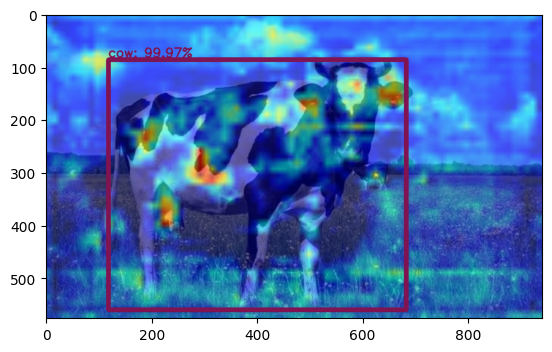

In [14]:
plt.imshow(visual)